# Null text inversion

Null text inversion essentially involves 'inverting' a real image into latent space. This way, we have intermediates which are more amenable to editing. In the context of DragonDiffusion, if we are beginning with a real image, then we will use this technique to 'reconstruct' the image iteratively from the latent representation. Then, we'll use the features of the reconstructed version to guide the editing process. This is what gives us access to the attention matrices that are key to maintaining high consistency between original and edited images.

If the image we want to edit has been generated, we'll just use the intermediate latents instead of this inversion process. Imagine the workflow as generating an image, storing the intermediate latents, and then using those intermediate latents for editing in the event that the user wants to edit. Null text inversion gives us the flexibility that we can do the same thing regardless of whether or not the image we want to edit is 'real' or generated.

In [ ]:
#| default_exp nulltext

In [ ]:
# | export
from __future__ import annotations
import math, random, torch, matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, shutil, os, gzip, pickle, re, copy
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
from functools import partial
import fastcore.all as fc
from glob import glob

from torch import tensor, nn, optim
import torch.nn.functional as F
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from diffusers import UNet2DModel
from torch.utils.data import DataLoader, default_collate
from torch.nn import init

from einops import rearrange
from fastprogress import progress_bar
from PIL import Image
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from dataclasses import dataclass
from diffusers import LMSDiscreteScheduler, UNet2DConditionModel, AutoencoderKL, DDIMScheduler
from transformers import AutoTokenizer, CLIPTextModel
from diffusers.utils import BaseOutput

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput, deprecate
from diffusers.schedulers.scheduling_utils import SchedulerMixin

from dragon_diffusion.core import *
from dragon_diffusion.masks import *

In [ ]:
model = UNet2DConditionModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='unet').cuda()
tokenizer = AutoTokenizer.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='tokenizer')
text_encoder = CLIPTextModel.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained('runwayml/stable-diffusion-v1-5', subfolder='vae').to('cuda')

In [ ]:
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear')

prompt = 'an astronaut floating in space'
uncond_embeddings = get_embeddings("", text_encoder, tokenizer, concat_unconditional=False, device='cuda')
cond_embeddings = get_embeddings(prompt, text_encoder, tokenizer, concat_unconditional=False, device='cuda')

In [ ]:
#| export
@torch.no_grad()
def ddim_inversion(latents, cond_embeddings, scheduler, model):
    next_latents = latents
    all_latents = [latents.detach().cpu()]

    for t, next_t in progress_bar([(i,j) for i,j in zip(reversed(scheduler.timesteps[1:]), reversed(scheduler.timesteps[:-1]))], leave=False, comment='inverting image...'):
        latent_model_input = scheduler.scale_model_input(next_latents, t)
        noise_pred = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample

        alpha_prod_t =  scheduler.alphas_cumprod[t]
        alpha_prod_t_next = scheduler.alphas_cumprod[next_t]
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_next = 1 - alpha_prod_t_next

        f = (next_latents - beta_prod_t ** 0.5 * noise_pred) / (alpha_prod_t ** 0.5)
        next_latents = alpha_prod_t_next ** 0.5 * f + beta_prod_t_next ** 0.5 * noise_pred
        all_latents.append(next_latents.detach().cpu())

    return all_latents

In [ ]:
img_path = '/home/astronaut.jpg'
height, width = 512, 512
latents = encode_img(img_path, height, width, vae) ## start from existing image
steps = 50
device = 'cuda'
scheduler.set_timesteps(steps)
all_latents = ddim_inversion(latents, cond_embeddings, scheduler, model)

In [ ]:
#| export
def null_text_inversion(model, scheduler, all_latents, embeddings, inner_steps=10, lr=0.01, guidance=7.5, generator=None, device='cuda'):
    cond_embeddings, uncond_embeddings = embeddings.chunk(2)
    
    # set up uncond_embeddings as a parameter
    uncond_embeddings = torch.nn.Parameter(uncond_embeddings, requires_grad=True)
    uncond_embeddings = uncond_embeddings.detach()
    uncond_embeddings.requires_grad_(True)

    # Initialize the optimizer
    optimizer = optim.Adam(
        [uncond_embeddings],  # only optimize the embeddings
        lr=lr,
    )

    # step_ratio = pipe.scheduler.config.num_train_timesteps // pipe.scheduler.num_inference_steps
    cond_embeddings = cond_embeddings.detach()
    # input_embeddings = torch.cat([null_text_embeddings, text_embeddings], dim=0)
    # extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    results = []
    latents = all_latents[-1].to(device)
    
    for t, prev_latents in progress_bar([(i,j) for i,j in zip(scheduler.timesteps, reversed(all_latents[:-1]))], leave=False, comment='null text optimising...'):
        prev_latents = prev_latents.to(device).detach()
        
        # expand the latents if we are doing classifier free guidance
        latent_model_input = scheduler.scale_model_input(latents, t).detach()
        cond = model(latent_model_input, t, encoder_hidden_states=cond_embeddings).sample.detach()
        for _ in progress_bar(range(inner_steps), leave=False):
            uncond = model(latent_model_input, t, encoder_hidden_states=uncond_embeddings).sample
            noise_pred = uncond + guidance * (cond - uncond)
            
            prev_latents_pred = scheduler.step(noise_pred, t, latents).prev_sample
            loss = F.mse_loss(prev_latents_pred, prev_latents).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        results.append(cond_embeddings.detach().cpu())
        latents = prev_latents_pred.detach()
        
    return all_latents[-1], results

In [ ]:
embeddings = torch.cat([cond_embeddings, uncond_embeddings])
z_T, all_null_texts = null_text_inversion(model, scheduler, all_latents, embeddings, inner_steps=10)

In [ ]:
#| export
@torch.no_grad()
def reconstruct(model, scheduler, latents, cond_embeddings, null_uncond_embeddings, guidance=7.5, generator=None, eta=0.0, device='cuda', vae=None, decode=False):
    # extra_step_kwargs = pipe.prepare_extra_step_kwargs(generator, eta)
    if decode: assert vae is not None
    latents = latents.to(device)
    for i, (t, null_embed) in enumerate(progress_bar([(i,j) for i, j in zip(scheduler.timesteps, null_uncond_embeddings)], leave=False, comment='reconstructing image...')):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        embeddings = torch.cat([null_embed.to(device), cond_embeddings])
        
        noise_pred = model(latent_model_input, t, encoder_hidden_states=embeddings).sample
        uncond, cond = noise_pred.chunk(2)
        noise_pred = uncond + guidance * (cond - uncond)
       
        latents = scheduler.step(noise_pred, t, latents).prev_sample
    
    if decode:
        image = decode_img(latents, vae)
        return image
    return latents

In [ ]:
recon_img = reconstruct(model, scheduler, z_T, cond_embeddings, all_null_texts, guidance=1, vae=vae, decode=True)

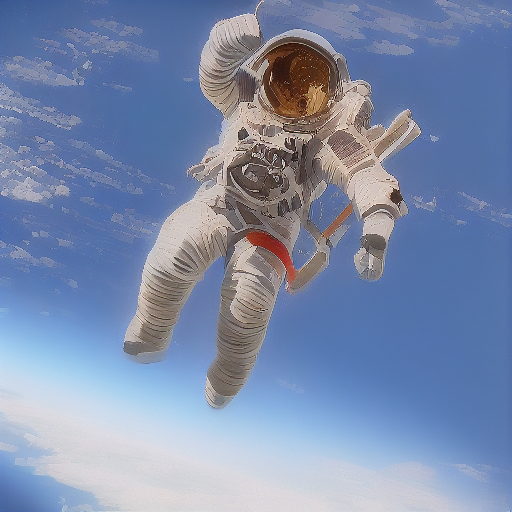

In [ ]:
recon_img

Proof of concept. This isn't perfect but will come back to this in the event that its not sufficient for Dragon Diffusion.

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()